## TD Models

TD-learning family models:
1. <a href='#oneStepTD'> TD(0) </a>
2. <a href='#oneStepSARSA'> One-step SARSA </a>
3. n-step SARSA
4. Actor-critic:
    * Some Theory: <a href='http://incompleteideas.net/book/first/ebook/node66.html'>Actor-Critic Methods</a>
    * Possible Implementation: <a href='https://www.nature.com/articles/s41598-017-18004-7'> A hippocampo-cerebellar centred network for the learning and execution of sequence-based navigation </a>

In [1]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys

module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [3]:
# Define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}
quad1 = [3,7,8,15,16,17,18,31,32,33,34,35,36,37,38,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78]
quad2 = [4,9,10,19,20,21,22,39,40,41,42,43,44,45,46,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94]
quad3 = [5,11,12,23,24,25,26]
quad3.extend(list(range(47,54)))
quad3.extend(list(range(95,110)))
quad4 = [6,13,14,27,28,29,30]
quad4.extend(list(range(55,62)))
quad4.extend(list(range(111,126)))

In [4]:
def extract_rew_traj(classic=False):
    # Classic mode: Storing trajectories up until the first reward node visit (assume immediate reward)
    # Default mode: Storing trajectories up until the first reward receipt (could be multiple reward node visits)
    print('Extracting trajectories with classic mode: ', classic)
    
    TrajS = np.ones((10,20,3000)) * -1

    if classic:
        for mouseID, nickname in enumerate(RewNames):
            tf = LoadTraj(nickname+'-tf')
            reward_found = False
            for boutID in np.arange(len(tf.no)):
                # find the number of steps till the first reward
                for step, entry in enumerate(tf.no[boutID]):
                    node, frame = entry
                    if node==116:
                        TrajS[mouseID,boutID,step] = tf.no[boutID][step,0]
                        reward_found = True
                        break
                    else:
                        TrajS[mouseID,boutID,step] = tf.no[boutID][step,0]
                if reward_found:
                    break
    else:
        for mouseID, nickname in enumerate(RewNames):
            tf = LoadTraj(nickname+'-tf')
            reward_found = False
            for boutID, reFrames in enumerate(tf.re):
                waterport_visit_frames = tf.no[boutID][np.where(tf.no[boutID][:,0]==116)[0],1]
                if len(reFrames) != 0:
                    # find the number of steps till the first reward
                    for step, entry in enumerate(tf.no[boutID]):
                        node, frame = entry
                        if node==116:
                            wID = np.where(waterport_visit_frames==frame)[0][0]
                            if len(waterport_visit_frames)==1 and waterport_visit_frames[wID] <= reFrames[0][0]:
                                reFirst = step
                                TrajS[mouseID,boutID,0:reFirst+1] = tf.no[boutID][0:reFirst+1,0] 
                                reward_found = True
                                break
                            elif waterport_visit_frames[-1]==frame and waterport_visit_frames[wID] <= reFrames[0][0]:
                                reFirst = step
                                TrajS[mouseID,boutID,0:reFirst+1] = tf.no[boutID][0:reFirst+1,0] 
                                reward_found = True
                                break
                            elif waterport_visit_frames[wID] <= reFrames[0][0] and reFrames[0][0] <= waterport_visit_frames[wID+1]:
                                reFirst = step
                                TrajS[mouseID,boutID,0:reFirst+1] = tf.no[boutID][0:reFirst+1,0] 
                                reward_found = True
                                break
                        else:
                            TrajS[mouseID,boutID,step] = tf.no[boutID][step,0]

                else:
                    TrajS[mouseID,boutID,0:len(tf.no[boutID][:,0])] = tf.no[boutID][:,0]

                if reward_found:
                    break

    # Save extracted trajectories
    if classic:
        pickle.dump(TrajS,open('stan/pre_reward_traj/rewMICE_classic.p','wb'))
    else:
        pickle.dump(TrajS,open('stan/pre_reward_traj/rewMICE.p','wb'))
    
    # Save number of unsuccessful reward node visits
    if not classic:
        nonRew_RVisits = np.zeros((10,20))
        for mouseID in np.arange(10):
            for boutID in np.arange(20):
                nonRew_RVisits[mouseID,boutID] = len(np.where(TrajS[mouseID,boutID,:]==116)[0])

                # Checking if the bout is rewarded
                if TrajS[mouseID,boutID+1,0] == -1:
                    nonRew_RVisits[mouseID,boutID] -= 1
                    break
        pickle.dump(nonRew_RVisits,open('stan/pre_reward_traj/nonRew_RVisits.p','wb'))

In [5]:
def get_SAnodemap(S,A):
    '''
    Generate an array with the same dimensions as state-action value look up table but with entries as node labels
    '''
    # Return nodemap for state-action values
    SAnodemap = np.ones((S+1,A)) * np.nan
    for node in np.arange(S):
        # Shallow level node available from current node
        if node%2 == 0:
            SAnodemap[node,0] = (node - 2) / 2
        elif node%2 == 1:
            SAnodemap[node,0] = (node - 1) / 2
        if SAnodemap[node,0] == -1:
            SAnodemap[node,0] = 127

        if node not in lv6_nodes:
            # Deeper level nodes available from current node
            SAnodemap[node,1] = node*2 + 1
            SAnodemap[node,2] = node*2 + 2

    # Nodes available from entry point
    SAnodemap[127,0] = np.nan
    SAnodemap[127,1] = 0
    SAnodemap[127,2] = np.nan
    
    return SAnodemap

In [6]:
def nodes2cell(state_hist_all):
    state_hist_cell = []
    state_hist_xy = {}
    ma=NewMaze(6)
    for epID, episode in enumerate(state_hist_all.values()):
        cells = []
        cells.extend([7])
        for id,node in enumerate(episode):
            if id != 0 and node != 127:
                if node > episode[id-1]: 
                    # if going to a deeper node
                    cells.extend(ma.ru[node])
                elif node < episode[id-1]: 
                    # if going to a shallower node
                    reverse_path = list(reversed(ma.ru[episode[id-1]]))
                    reverse_path = reverse_path + [ma.ru[node][-1]]
                    cells.extend(reverse_path[1:])
        if node==127:
            home_path = list(reversed(ma.ru[0]))
            cells.extend(home_path[1:])  # cells from node 0 to maze exit
        state_hist_cell.append(cells)
        state_hist_xy[epID] = np.zeros((len(cells),2))
        state_hist_xy[epID][:,0] = ma.xc[cells] + np.random.choice([-1,1],len(ma.xc[cells]),p=[0.5,0.5])*np.random.rand(len(ma.xc[cells]))/2
        state_hist_xy[epID][:,1] = ma.yc[cells] + np.random.choice([-1,1],len(ma.yc[cells]),p=[0.5,0.5])*np.random.rand(len(ma.yc[cells]))/2
    return state_hist_cell, state_hist_xy

In [7]:
def plot_trajectory(episode, save_dir=None, mouse=None, figtitle=None):
    from matplotlib.collections import LineCollection
    from matplotlib import cm

    ma=NewMaze(6)
    # Draw the maze outline    
    fig,ax=plt.subplots(figsize=(9,9))
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=2,yflip=True,
              xhide=True,yhide=True,axes=ax)
    re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)

    #plt.axis('off'); # turn off the axes

    # Converting cell positions to x,y positions in the maze
    # ma.ce contains x,y positions for each cell
    if episode == 'all':
        for id, episode in enumerate(state_hist_xy):
            x = state_hist_xy[episode][:,0]
            y = state_hist_xy[episode][:,1]
            t = np.linspace(0,1,x.shape[0]) # your "time" variable

            # set up a list of (x,y) points
            points = np.array([x,y]).transpose().reshape(-1,1,2)

            # set up a list of segments
            segs = np.concatenate([points[:-1],points[1:]],axis=1)

            # make the collection of segments
            lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=2) # jet, viridis hot
            lc.set_array(t) # color the segments by our parameter

            # plot the collection
            lines=ax.add_collection(lc); # add the collection to the plot
    else:
        x = state_hist_xy[episode][:,0]
        y = state_hist_xy[episode][:,1]
        t = np.linspace(0,1,x.shape[0]) # your "time" variable

        # set up a list of (x,y) points
        points = np.array([x,y]).transpose().reshape(-1,1,2)

        # set up a list of segments
        segs = np.concatenate([points[:-1],points[1:]],axis=1)

        # make the collection of segments
        lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=2) # jet, viridis hot
        lc.set_array(t) # color the segments by our parameter

        # plot the collection
        lines=ax.add_collection(lc); # add the collection to the plot

    cax=fig.add_axes([1.05, 0.05, 0.05, 0.9])
    cbar=fig.colorbar(lines,cax=cax)
    cbar.set_ticks([0,1])
    cbar.set_ticklabels(['Entry','Exit'])
    cbar.ax.tick_params(labelsize=18)
    fig.suptitle(figtitle)
    fig = plt.gcf()
    fig.savefig(save_dir+mouse+'.png')
    plt.show()

In [8]:
def TD0_classic(best_sub_fits,fit_group,fit_group_data):
    '''
    one-step TD where we assume the first visit to the reward port is immediately rewarded
    '''
    # Set environment parameters
    S = 127
    A = 3
    RT = 1
    nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states
    state_hist_AllMice = {}
    valid_bouts = []
    avg_count = 1
    episode_cap = 500
    value_cap = 1e5
    success = 1
    
    if fit_group == 'Rew':
        TrajS = pickle.load(open(fit_group_data,'rb')).astype(int)
        
    for mouseID in np.arange(10):
        # Set model parameters
        alpha = best_sub_fits[mouseID][0]  # learning rate
        beta = best_sub_fits[mouseID][1]   # softmax exploration - exploitation
        gamma = best_sub_fits[mouseID][2]
        R = 0
        
        # number of episodes to train over which are real bouts beginning at node 0 
        # and exploring deeper into the maze, which is > than a trajectory length of 2 (node 0 -> node 127)
        valid_boutID = np.where(TrajS[mouseID,:,2]!=-1)[0]
        N = len(valid_boutID)
        valid_bouts.extend([N])
        
        for count in np.arange(avg_count):
            # Initialize model parameters
            V = np.random.rand(S+1)  # state-action values
            V[127] = 0  # setting action-values of maze entry to 0
            V[116] = 0  # setting action-values of reward port to 0
            state_hist_mouse = {}
            R_visits = 0

            for n in np.arange(N):
                valid_episode = False
                episode_attempt = 0
                
                # Extract from real mouse trajectory the terminal node in current bout and trajectory length
                end = np.where(TrajS[mouseID,valid_boutID[n]]==-1)[0][0]
                valid_traj = TrajS[mouseID,valid_boutID[n],0:end]
                
                # Back-up a copy of state-values to use in case the next episode has to be discarded
                V_backup = np.copy(V)
                
                # Begin episode
                while not valid_episode and episode_attempt < episode_cap:
                    # Initialize starting state,s0 to node 0
                    s = 0
                    state_hist = []
                    
                    while s!=127 and s!=116:
                        # Record current state
                        state_hist.extend([s])

                        # Use softmax policy to select action, a at current state, s
                        if s in lv6_nodes:
                            aprob = [1,0,0]
                        else:
                            betaV = [np.exp(beta*V[int(val)]) for val in nodemap[s,:]]
                            aprob = []
                            for atype in np.arange(3):
                                if np.isinf(betaV[atype]):
                                    aprob.extend([1])
                                elif np.isnan(betaV[atype]):
                                    aprob.extend([0])
                                else:
                                    aprob.extend([betaV[atype]/np.nansum(betaV)])
                        
                        # Check for invalid probabilities
                        for i in aprob:
                            if np.isnan(i):
                                print('Invalid action probabilities ', aprob, betaV, s)
                                print(alpha, beta, gamma, mouseID, n)
                        if np.sum(aprob) < 0.999:
                            print('Invalid action probabilities, failed summing to 1: ', aprob, betaV, s)
                        a = np.random.choice([0,1,2],1,p=aprob)[0]

                        # Take action, observe reward and next state
                        sprime = int(nodemap[s,a])
                        if sprime == 116:
                            R = 1  # Receive a reward of 1 when transitioning to the reward port
                        else:
                            R = 0

                        # Update action-value of previous state value, V[s]
                        #V[s] += alpha * (R + gamma*V[sprime] - V[s])
                        V[s] += R + gamma*V[sprime] - alpha*V[s]
                        if np.isnan(V[s]):
                            print('Warning invalid state-value: ', s, sprime, V[s], V[sprime], alpha, beta, gamma, R)
                        elif np.isinf(V[s]):
                            print('Warning infinite state-value: ', V)
                        elif V[s]>value_cap:
                            #print('Warning state value exceeded upper bound. Might approach infinity')
                            V[s] = value_cap
                            
                        # Shift state values for the next time step
                        s = sprime
                        
                        # Check whether to abort the current episode
                        if len(state_hist) > len(valid_traj):
                            #print('Trajectory too long. Aborting episode')
                            break
                    state_hist.extend([s])

                    # Find actual end node for mouse trajectory in the current bout/episode
                    if s == valid_traj[-1]:
                        #if len(state_hist) < 200:
                        if (len(state_hist) > 2) and (len(state_hist) > 0.5 * len(valid_traj)) and (len(state_hist) <= len(valid_traj)):
                            state_hist_mouse[n] = state_hist
                            valid_episode = True
                    else:
                        R = 0
                        V = np.copy(V_backup)
                        #print('Rejecting episode of length: ', len(state_hist), ' for mouse ', mouseID, ' bout ', valid_boutID[n], ' traj length ', len(valid_traj))
                        episode_attempt += 1
                        
                if episode_attempt >= episode_cap:
                    print('Failed to generate episodes for mouse ', mouseID, ' with parameter set: ', alpha, beta, gamma)
                    success = 0
                    break
            state_hist_AllMice[mouseID] = state_hist_mouse
            
            #print('Mouse', mouseID, ' max state-value', np.max(V))
    return state_hist_AllMice, valid_bouts, success

In [9]:
def TD0(best_sub_fits,fit_group):
    # Set environment parameters
    S = 127
    A = 3
    RT = 1
    nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states
    state_hist_AllMice = {}
    valid_bouts = []
    avg_count = 1
    episode_cap = 500
    value_cap = 1e5
    success = 1
    
    if fit_group == 'Rew':
        TrajS = pickle.load(open('stan/pre_reward_traj/rewMICE.p','rb')).astype(int)
        
    for mouseID in np.arange(10):
        # Set model parameters
        alpha = best_sub_fits[mouseID][0]  # learning rate
        beta = best_sub_fits[mouseID][1]   # softmax exploration - exploitation
        gamma = best_sub_fits[mouseID][2]
        R = 0
        
        # number of episodes to train over which are real bouts beginning at node 0 
        # and exploring deeper into the maze, which is > than a trajectory length of 2 (node 0 -> node 127)
        valid_boutID = np.where(TrajS[mouseID,:,2]!=-1)[0]
        N = len(valid_boutID)
        valid_bouts.extend([N])
        
        for count in np.arange(avg_count):
            # Initialize model parameters
            V = np.random.rand(S+1)  # state-action values
            V[127] = 0  # setting action-values of maze entry to 0
            V[116] = 0  # setting action-values of reward port to 0
            state_hist_mouse = {}
            R_visits = 0

            for n in np.arange(N):
                valid_episode = False
                episode_attempt = 0
                total_R_visits = len(np.where(TrajS[mouseID,n,:]==116)[0])
                
                # Extract from real mouse trajectory the terminal node in current bout and trajectory length
                end = np.where(TrajS[mouseID,valid_boutID[n]]==-1)[0][0]
                valid_traj = TrajS[mouseID,valid_boutID[n],0:end]
                
                # Back-up a copy of state-values to use in case the next episode has to be discarded
                V_backup = np.copy(V)
                
                # Begin episode
                while not valid_episode and episode_attempt < episode_cap:
                    # Initialize starting state,s0 to node 0
                    s = 0
                    state_hist = []
                    
                    while s!=127 and (s!=116 or R==0):
                        # Record current state
                        state_hist.extend([s])

                        # Use softmax policy to select action, a at current state, s
                        if s in lv6_nodes:
                            aprob = [1,0,0]
                        else:
                            betaV = [np.exp(beta*V[int(val)]) for val in nodemap[s,:]]
                            aprob = []
                            for atype in np.arange(3):
                                if np.isinf(betaV[atype]):
                                    aprob.extend([1])
                                elif np.isnan(betaV[atype]):
                                    aprob.extend([0])
                                else:
                                    aprob.extend([betaV[atype]/np.nansum(betaV)])
                        
                        # Check for invalid probabilities
                        for i in aprob:
                            if np.isnan(i):
                                print('Invalid action probabilities ', aprob, betaV, s)
                                print(alpha, beta, gamma, mouseID, n)
                        if np.sum(aprob) < 0.999:
                            print('Invalid action probabilities, failed summing to 1: ', aprob, betaV, s)
                        a = np.random.choice([0,1,2],1,p=aprob)[0]

                        # Take action, observe reward and next state
                        sprime = int(nodemap[s,a])
                        if sprime == 116:
                            R_visits += 1
                            if R_visits >= total_R_visits:
                                R = 1  # Receive a reward of 1 when transitioning to the reward port
                            else:
                                R = 0
                        else:
                            R = 0

                        # Update action-value of previous state value, V[s]
                        #V[s] += alpha * (R + gamma*V[sprime] - V[s])
                        V[s] += R + gamma*V[sprime] - alpha*V[s]
                        if np.isnan(V[s]):
                            print('Warning invalid state-value: ', s, sprime, V[s], V[sprime], alpha, beta, gamma, R)
                        elif np.isinf(V[s]):
                            print('Warning infinite state-value: ', V)
                        elif V[s]>value_cap:
                            #print('Warning state value exceeded upper bound. Might approach infinity')
                            V[s] = value_cap
                            
                        # Shift state values for the next time step
                        s = sprime
                        
                        # Check whether to abort the current episode
                        if len(state_hist) > len(valid_traj):
                            #print('Trajectory too long. Aborting episode')
                            break
                    state_hist.extend([s])

                    # Find actual end node for mouse trajectory in the current bout/episode
                    if s == valid_traj[-1]:
                        #if len(state_hist) < 200:
                        if (len(state_hist) > 2) and (len(state_hist) <= len(valid_traj)):
                            state_hist_mouse[n] = state_hist
                            valid_episode = True
                    else:
                        R = 0
                        V = np.copy(V_backup)
                        #print('Rejecting episode of length: ', len(state_hist), ' for mouse ', mouseID, ' bout ', valid_boutID[n], ' traj length ', len(valid_traj))
                        episode_attempt += 1
                        
                if episode_attempt >= episode_cap:
                    print('Failed to generate episodes for mouse ', mouseID, ' with parameter set: ', alpha, beta, gamma)
                    success = 0
                    break
            state_hist_AllMice[mouseID] = state_hist_mouse
            
            #print('Mouse', mouseID, ' max state-value', np.max(V))
    return state_hist_AllMice, valid_bouts, success

In [10]:
def oneStepSARSA(best_sub_fits,fit_group):
    # Set environment parameters
    S = 127
    A = 3
    RT = 1
    avg_count = 1
    Q_nodemap = get_SAnodemap(S,A)
    state_hist_AllMice = {}
    valid_bouts = []
    
    if fit_group == 'Rew':
        TrajS = pickle.load(open('stan/pre_reward_traj/rewMICE.p','rb')).astype(int)

    for mouseID in np.arange(10):
        # Set model parameters
        alpha = best_sub_fits[mouseID][0]  # learning rate
        beta = best_sub_fits[mouseID][1]   # softmax exploration - exploitation
        gamma = best_sub_fits[mouseID][2]
        # number of episodes to train over which are real bouts beginning at node 0 and exploring deeper into the maze
        N = len(np.where(TrajS[mouseID,np.where(TrajS[mouseID,:,1]!=-1)[0],1]!=127)[0])
        valid_bouts.extend([N])
        
        for count in np.arange(avg_count):
            # Initialize model parameters
            Q = np.random.rand(S+1,A)  # state-action values
            Q[127,:] = 0  # setting action-values of reward port to 0
            Q[np.isnan(Q_nodemap)] = np.nan
            state_hist_mouse = {}
            total_reward = 0

            for n in np.arange(N):
                # Initialize starting state,s0 to node 0 and selection action a0
                aprob = []
                choices = []
                s = 0
                for atype in np.arange(3):
                    aprob.extend([np.exp(beta*Q[s,atype])/np.nansum(np.exp(beta*Q[s,:]))])
                a = np.random.choice([0,1,2],1,p=aprob)[0]
                state_hist = []

                # Begin episode
                while s!=127 and s!=116:
                    # Record current state
                    state_hist.extend([s])

                    # Take action, observe reward and next state
                    sprime = int(Q_nodemap[s,a])
                    if sprime == 116:
                        R = 1  # Receive a reward of 1 when transitioning to the reward port
                        total_reward += 1
                    else:
                        R = 0

                    # Choose next action, aprime from new state, sprime
                    aprob = []
                    choices = []
                    for atype in np.arange(3):
                        if not np.isnan(Q[sprime,atype]):
                            aprob.extend([np.exp(Q[sprime,atype])/np.nansum(np.exp(Q[sprime,:]))])
                            choices.extend([atype])
                    aprime = np.random.choice(choices,1,p=aprob)[0]

                    # Update action-value of previous state-action pair, Q[s,a]
                    Q[s,a] += alpha * (R + gamma*Q[sprime,aprime] - Q[s,a])

                    # Shift state and action values for the next time step
                    a = aprime
                    s = sprime
                state_hist.extend([s])
                state_hist_mouse[n] = state_hist
            state_hist_AllMice[mouseID] = state_hist_mouse
            
    return state_hist_AllMice, valid_bouts

In [11]:
# Extract first reward trajectories from real mice data
extract_traj = False
classic = False
if extract_traj:
    extract_rew_traj(classic)

## Visualize trajectory lengths over time

In [ ]:
# Plotting trajectory lengths vs bouts for all mice
fig, axs = plt.subplots(2,5, constrained_layout=True, figsize=(20,15))
for mouseID, nickname in enumerate(RewNames):
    i = mouseID//5
    j = mouseID%5
    tf = LoadTraj(nickname+'-tf')
    traj_lengths = []
    for boutID, bout in enumerate(tf.no):
        traj_lengths.extend([len(tf.no[boutID])])
    axs[i,j].bar(np.arange(1,len(tf.no)+1), traj_lengths)
    axs[i,j].set_title(nickname)
    axs[1,j].set_xlabel('Bouts')
    axs[i,0].set_ylabel('No. of steps')
plt.savefig('figures/all_trajectories.png')
    
fig2, axs2 = plt.subplots(2,5, constrained_layout=True, figsize=(20,15))
for mouseID, nickname in enumerate(RewNames):
    i = mouseID//5
    j = mouseID%5
    tf = LoadTraj(nickname+'-tf')
    traj_lengths2 = []
    rewardID = [] 
    visitsteps = []
    drinkstep = []
    first_drink=False
    for boutID, bout in enumerate(tf.no[0:30]):
        traj_lengths2.extend([len(tf.no[boutID])])
        if 116 in bout:
            visits = np.where(tf.no[boutID]==116)[0]
            rewardID.extend([boutID]*len(visits))
            visitsteps.extend(visits)
        if len(tf.re[boutID])>0 and not first_drink:
            drinkID = boutID
            drinkframe = tf.re[boutID][0][0]
            for attempt in visits:
                if drinkframe > tf.no[boutID][attempt][1]:
                    drinkstep = attempt
                    break
            first_drink=True
    
    axs2[i,j].bar(np.arange(len(tf.no[0:30])), traj_lengths2, color='#FFFAC8', edgecolor='#FFD500')
    axmin, axmax = axs2[i,j].get_ylim()
    ypos = [traj_lengths2[val-1] + (axmax-axmin)*0.1 for val in rewardID]
    axs2[i,j].plot(rewardID,visitsteps,'b*',label='reward port visit')
    axs2[i,j].plot(drinkID,drinkstep,'k*',label='first drink')
    axs2[i,j].set_title(nickname)
    axs2[1,j].set_xlabel('Bouts')
    axs2[i,0].set_ylabel('No. of steps')
    axs2[0,0].legend()
plt.savefig('figures/first30_trajectories.png')

## Plot Quadrant Behavior

In [ ]:
# Sorting which quarters of the maze a mouse visits during each trajectory
tf = LoadTraj('C1'+'-tf')
quad_visit = []
for bout in np.arange(3,20):
    for val in tf.no[bout]:
        if val[0] in quad1:
            quad_visit.extend([1])
        elif val[0] in quad2:
            quad_visit.extend([2])
        elif val[0] in quad3:
            quad_visit.extend([3])
        elif val[0] in quad4:
            quad_visit.extend([4])
    plt.figure(figsize=(20,15))
    plt.plot(np.arange(1,len(quad_visit)+1),quad_visit,'*')
    plt.title('Bout %i' %(bout+1))

### TD(0) <a id='#oneStepTD'></a>
Online TD-control algorithm which estimates state values, V(s)
 - States: 127 maze nodes
 - Terminal states: maze entry, 127 and reward port, 116
 - Rewards: 0 on all states except for 1 on the water port
 
 Pseudocode
- Softmax action selection policy: $\pi(a | s_i) = \frac{e^{\beta*V(s_{ij})}}{e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})}}$, where j indexes the 3 neighboring nodes to $s_i$
- Action-value update: $V(s) \leftarrow V(s) + \alpha*(R + \gamma*V(s') - V(s))$

 Re-parametrized version where $\beta = \beta * \alpha$ and $V(s) = \frac{V(s)}{\alpha}$
- original action-value update: $V(s) \leftarrow (1-\alpha)V(s) + \alpha(R + \gamma * V(s'))$
- new action-value update: $V(s) \leftarrow (1-\alpha)V(s) + R + \alpha * \gamma * V(s')$

In [ ]:
# Define TD(0) model

# Set environment parameters
S = 127
A = 3
RT = 1
nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states

# Set model parameters
alpha = 0.01  # learning rate
gamma = 1
beta = 10  # softmax exploration - exploitation
N = 5  # number of episodes to train over
speed = 10  # mice speed in nodes per sec
timeout = 90  # units of seconds that the reward port times out

# Simulation settings
reparam = False
avg_count = 50
avg_V = np.zeros(S+1)

for count in np.arange(avg_count):
    # Initialize model parameters
    V = np.zeros(S+1) #np.random.rand(S+1)  # state-action values
    V[127] = 0  # setting action-values of maze entry to 0
    V[116] = 0  # setting action-values of reward port to 0
    state_hist_all = {}
    total_reward = 0
    t = timeout

    for n in np.arange(N):
        # Initialize starting state,s0 to node 0
        s = 0
        state_hist = []

        # Begin episode
        while s!=127: #and s!=116:
            # Record current state
            state_hist.extend([s])

            # Use softmax policy to select action, a at current state, s
            betaV = [np.exp(beta*V[int(val)]) if val >= 0 else 0 for val in nodemap[s,:]]
            aprob = []
            if s not in lv6_nodes:
                for atype in np.arange(3):
                    prob = betaV[atype]/np.nansum(betaV)
                    if not np.isnan(prob):
                        aprob.extend([prob])
                    else:
                        aprob.extend([1])
                a = np.random.choice([0,1,2],1,p=aprob)[0]
            elif s in lv6_nodes:
                a = 0  # when s is an end node, chose action for lower level node

            # Observe reward and next state based on selected action
            sprime = int(nodemap[s,a])
            if sprime == 116 and t >= timeout:
                R = 1  # Receive a reward of 1 when transitioning to the reward port
                total_reward += 1
                t = 0  # Reset timer
            else:
                R = 0
                t += speed  # Increment time from last reward

            # Update action-value of previous state value, V[s]
            if not reparam:
                V[s] += alpha * (R + gamma*V[sprime] - V[s])
            elif reparam:
                V[s] += R + gamma*V[sprime] - alpha*V[s]

            # Shift state values for the next time step
            s = sprime
        state_hist.extend([s])
        state_hist_all[n] = state_hist

    avg_V += deepcopy(V)
avg_V /= avg_count

In [ ]:
# Plotting state values
fig, ax = plt.subplots(figsize=(30,800))
axhandle = ax.imshow(np.transpose(np.reshape(avg_V,(S+1,1))),cmap='YlGnBu')
ax.invert_yaxis()
ax.set_ylabel('V (s)')
ax.set_xticks(np.arange(0,127,5))
ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
ax.set_xlabel('Nodes')
ax.set_title('Average state values for TD(0) with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
fig.colorbar(axhandle,fraction=0.005)

print('Max state value ', np.max(avg_V))
print('Min state value', np.min(avg_V))

# Set trajectories for plotting
state_hist_cell, state_hist_xy = nodes2cell(state_hist_all)
print('Total reward: ', total_reward)
print('alpha: ', alpha, ' beta: ', beta, ' gamma: ', gamma)
plot_trajectory('all')  # enter a single episode ID or enter 'all'

## Simulating Fake Data for Model Fitting

In [ ]:
sim_data = False
classic_TD = False  # Set to True to run TD0_classic where first reward node visit is rewarded
if sim_data:
    # Simulating data for parameter recovery
    da = 0.1
    db = 0.1
    dg = 0.1
    alpha_range = np.arange(0,1+da,da)
    beta_range = np.arange(0,1+db,db)
    gamma_range = np.arange(0,1+dg,dg)
    save_dir = 'Z:/'
    true_param = {}
    set_counter = 0
    for gamma in gamma_range:
        for beta in beta_range:
            for alpha in alpha_range:
                #alpha,beta,gamma = [0.2,10,0.2]
                print('Now simulating: ', set_counter, alpha, beta, gamma)
                true_param[set_counter] = [alpha, beta, gamma]

                best_sub_fits = {}
                for mouseID in np.arange(10):
                    best_sub_fits[mouseID] = [alpha,beta,gamma]

                if classic_TD:
                    state_hist_AllMice, valid_bouts, success = TD0_classic(best_sub_fits,'Rew')
                else:
                    state_hist_AllMice, valid_bouts, success = TD0(best_sub_fits,'Rew')

                simTrajS = np.ones((10,20,3000)) * -1
                for mouseID in np.arange(10):
                    for boutID in np.arange(len(state_hist_AllMice[mouseID])):
                        simTrajS[mouseID,boutID,0:len(state_hist_AllMice[mouseID][boutID])] = state_hist_AllMice[mouseID][boutID]
                if success == 0:
                    print('Not saving set ', set_counter)
                elif success == 1:
                    if classic_TD:
                        pickle.dump(simTrajS,open(save_dir+'stan/pre_reward_traj/full_search_classic/set'+str(set_counter)+'.p','wb'))
                    else:
                        pickle.dump(simTrajS,open(save_dir+'stan/pre_reward_traj/full_search/set'+str(set_counter)+'.p','wb'))

                # Increment counter
                set_counter += 1

    # Save parameter sets
    if classic_TD:
        pickle.dump(true_param,open(save_dir+'stan/pre_reward_traj/full_search_classic/true_param.p','wb'))
    else:
        pickle.dump(true_param,open(save_dir+'stan/pre_reward_traj/full_search/true_param.p','wb'))

In [ ]:
# Convert simulated trajectory from a dictionary to an array and save
save_traj = False
if save_traj:
    simTrajS = np.ones((10,20,3000)) * -1
    for mouseID in np.arange(10):
        for boutID in np.arange(len(state_hist_AllMice[mouseID])):
            simTrajS[mouseID,boutID,0:len(state_hist_AllMice[mouseID][boutID])] = state_hist_AllMice[mouseID][boutID]
    pickle.dump(simTrajS,open('stan/pre_reward_traj/set5_a0.05_b2_g0.7.p','wb'))

In [ ]:
# Set trajectories for plotting
for mouseID, nickname in enumerate(RewNames):
    state_hist_cell, state_hist_xy = nodes2cell(state_hist_AllMice[mouseID])
    print('Plotting simulated trajectory for', nickname, 'with', valid_bouts[mouseID],'valid bouts \n alpha: %.2f beta: %.2f gamma: %.2f' 
          %(best_sub_fits[mouseID][0], best_sub_fits[mouseID][1], best_sub_fits[mouseID][2]))
    plot_trajectory('all')  # enter a single episode ID or enter 'all'

## Testing Simulated Data with the Model (running model forward on simulated choices)

In [ ]:
# Set environment parameters
S = 127
A = 3
RT = 1
nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states
V = np.ones(S+1)
V[127] = 0  # setting action-values of maze entry to 0
V[116] = 0  # setting action-values of reward port to 0

# Load a simulated trajectory
TrajS = pickle.load(open(r'Z:\stan\pre_reward_traj\test_search_cl_nonrp_abgtest_smalldata\set0.p','rb')).astype(int)

# Create action sequence from trajectories
N = np.shape(TrajS)[0]          # setting the number of rewarded mice
B = np.shape(TrajS)[1]          # setting the maximum number of bouts until the first reward was sampled
BL = np.shape(TrajS)[2]
TrajA = np.zeros(np.shape(TrajS)).astype(int)
for n in np.arange(N):
    for b in np.arange(B):
        for bl in np.arange(BL - 1):
            if TrajS[n, b, bl + 1] != -1 and TrajS[n, b, bl] != 127:
                TrajA[n, b, bl] = np.where(nodemap[TrajS[n, b, bl], :] == TrajS[n, b, bl + 1])[0][0] + 1

# Set model parameters corresponding to simulated trajectory
alpha = 0.2
beta = 2
gamma = 0.2
mouseID = 0
boutsize = np.arange(len(TrajS[mouseID]))

for boutID in boutsize:
    for stepID, node in enumerate(TrajS[mouseID,boutID,:]):
        if node != -1 and node != 127 and node != 116:
            s = node  # Retrieve current state

            a = TrajA[0,boutID,stepID]  # Retrieve action taken at state s

            # Observe reward and next state based on selected action
            sprime = int(nodemap[s,a-1])
            if sprime == 116:
                R = 1  # Receive a reward of 1 when transitioning to the reward port
            else:
                R = 0

            # Update value of current state
            V[s] += alpha * (R + gamma*V[sprime] - V[s])

fig, ax = plt.subplots(figsize=(30,800))
axhandle = ax.imshow(np.transpose(np.reshape(V,(S+1,1))),cmap='RdPu')
ax.invert_yaxis()
ax.set_ylabel('V (s)')
ax.set_xticks(np.arange(0,127,5))
ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
ax.set_xlabel('Nodes')
ax.set_title('Current state values with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
fig.colorbar(axhandle,fraction=0.005)

## Evaluating Model Fits

Text(0.5, 1.0, 'Number of steps in simulated trajectories')

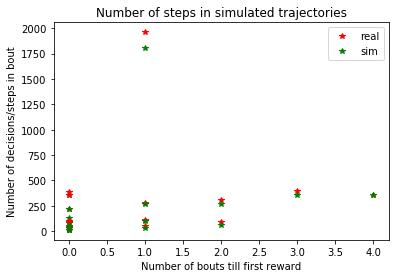

In [12]:
# Simulate data with fitted parameters
best_sub_fits = pickle.load(open(r'Z:\stan\stan_results\TD0_cl_nonrp_real\best_sub_fits.p','rb'))
fit_group = 'Rew'
fit_group_data = 'Z:/stan/pre_reward_traj/real_traj/rewMICE_classic.p'
state_hist_AllMice,valid_bouts,_ = TD0_classic(best_sub_fits,fit_group,fit_group_data)

# Plotting to compare simulated and actual trajectory lengths
sim_lengths_all = {}
real_lengths_all = {}
rand_LL = {}
TrajS = pickle.load(open(fit_group_data,'rb')).astype(int)
plt.figure()
for mouseID in np.arange(10):
    valid_boutID = np.where(TrajS[mouseID,:,2]!=-1)[0]
    real_lengths = []
    sim_lengths = []
    for boutID, bout in enumerate(valid_boutID):
        end = np.where(TrajS[mouseID,bout]==-1)[0][0]
        valid_traj = TrajS[mouseID,bout,0:end]
        random_choices = [val for val in valid_traj if val not in lv6_nodes]
        rand_LL[mouseID] = np.log(0.33) * len(random_choices) 
        real_lengths.extend([len(valid_traj)])
        sim_lengths.extend([len(state_hist_AllMice[mouseID][boutID])])
    real_lengths_all[mouseID] = real_lengths
    sim_lengths_all[mouseID] = sim_lengths
        
    plt.plot(np.arange(len(real_lengths_all[mouseID])), real_lengths_all[mouseID], 'r*', label='real')
    plt.plot(np.arange(len(real_lengths_all[mouseID])), sim_lengths_all[mouseID], 'g*', label='sim')
    if mouseID == 0:
        plt.legend()
plt.xlabel('Number of bouts till first reward')
plt.ylabel('Number of decisions/steps in bout')
plt.title('Number of steps in simulated trajectories')

In [13]:
rand_LL

{0: -330.38146210744014,
 1: -9.9779636206945,
 2: -12.195288869737723,
 3: -320.4034984867456,
 4: -69.8457453448615,
 5: -38.80319185825639,
 6: -1667.428587280503,
 7: -298.2302459963134,
 8: -32.15121611112672,
 9: -73.17173321842634}

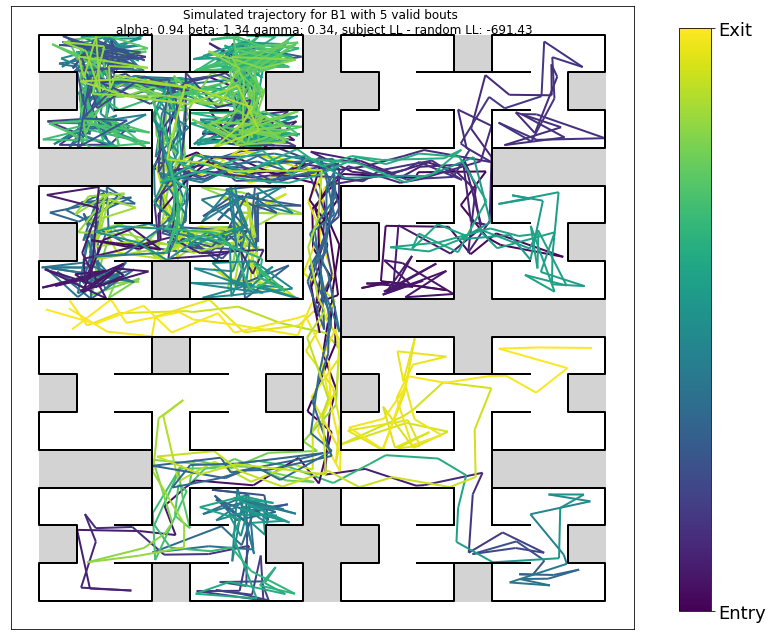

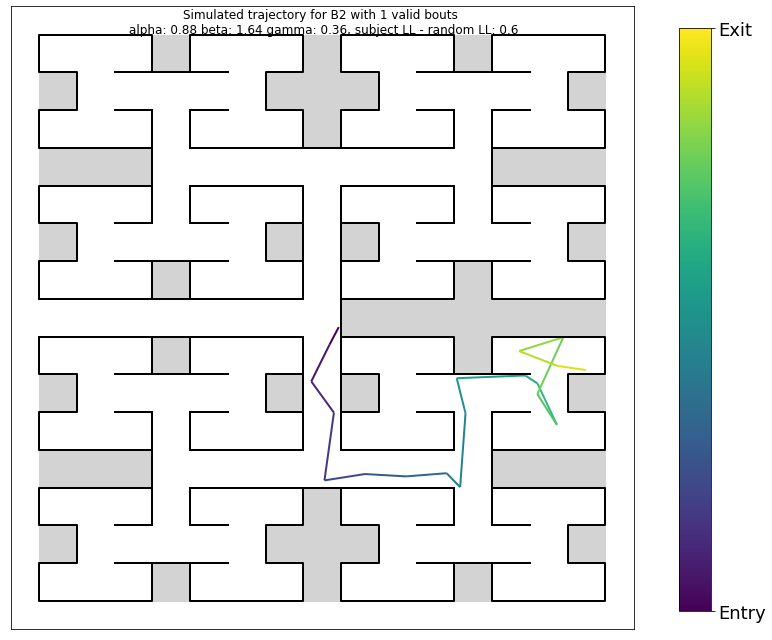

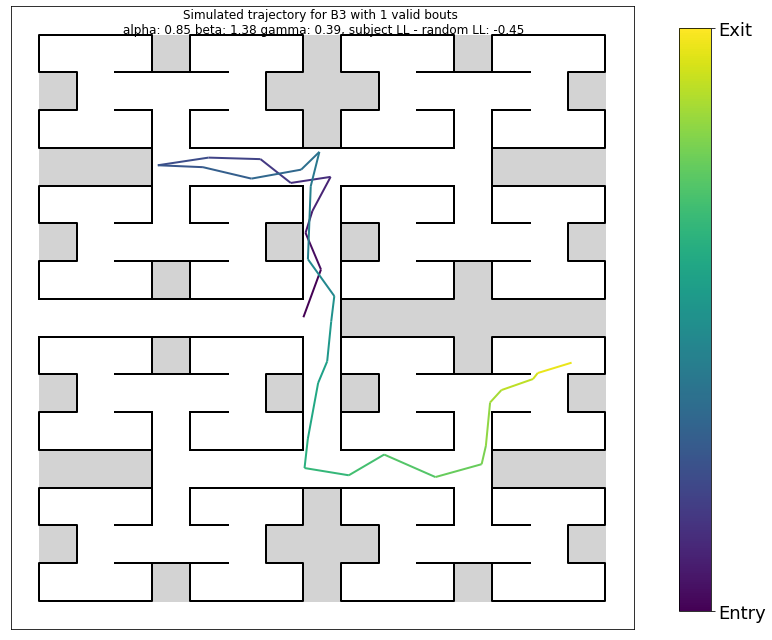

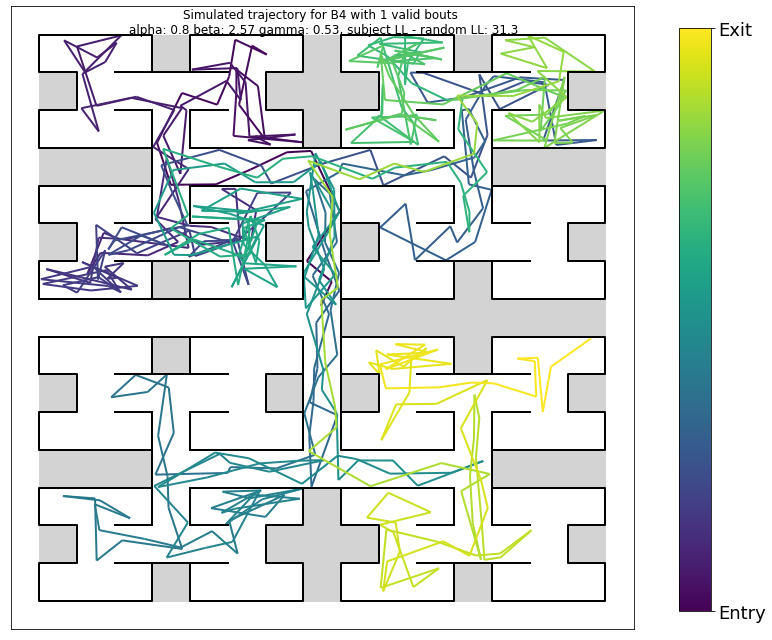

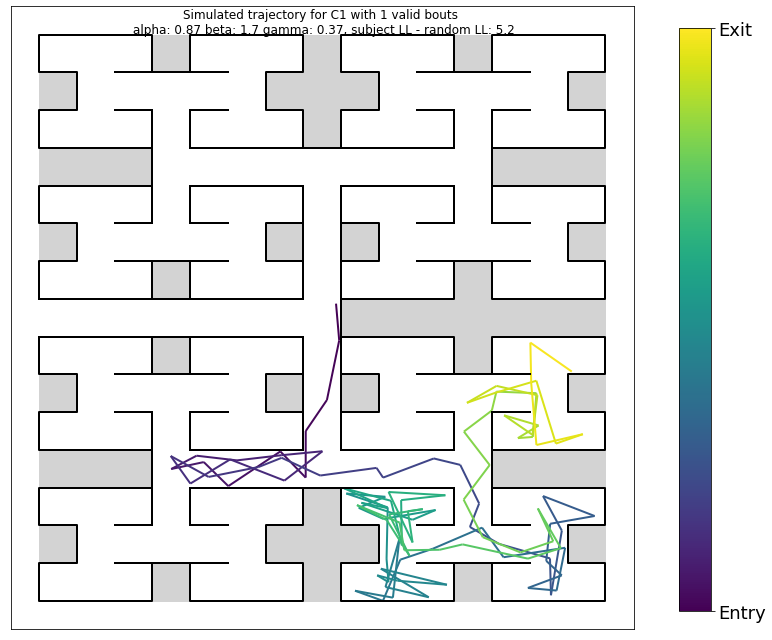

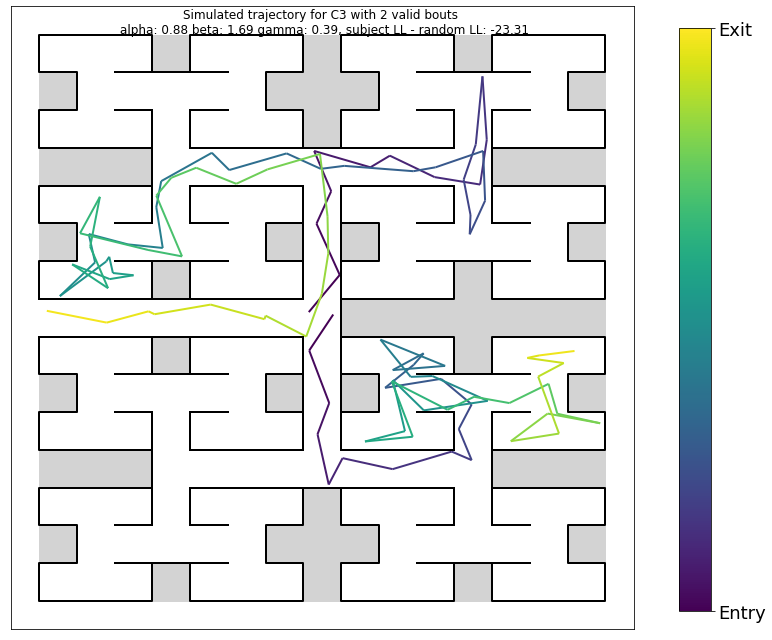

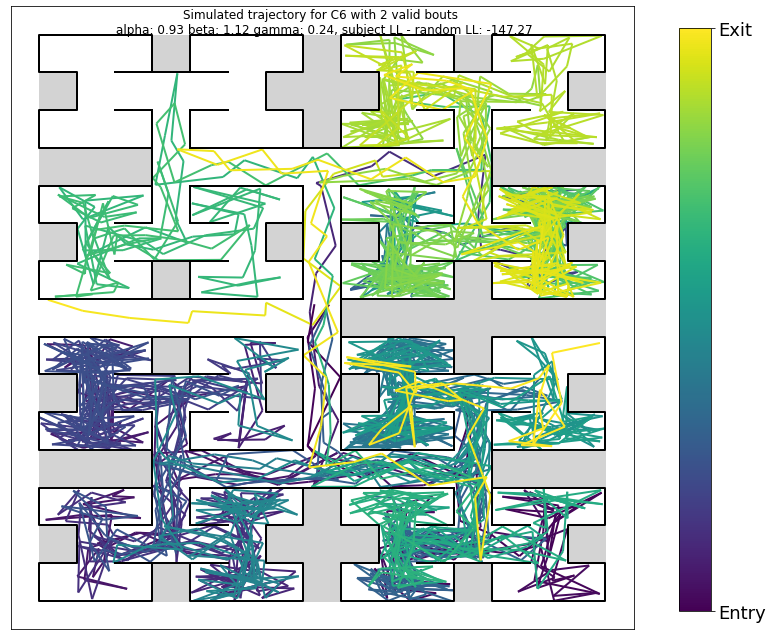

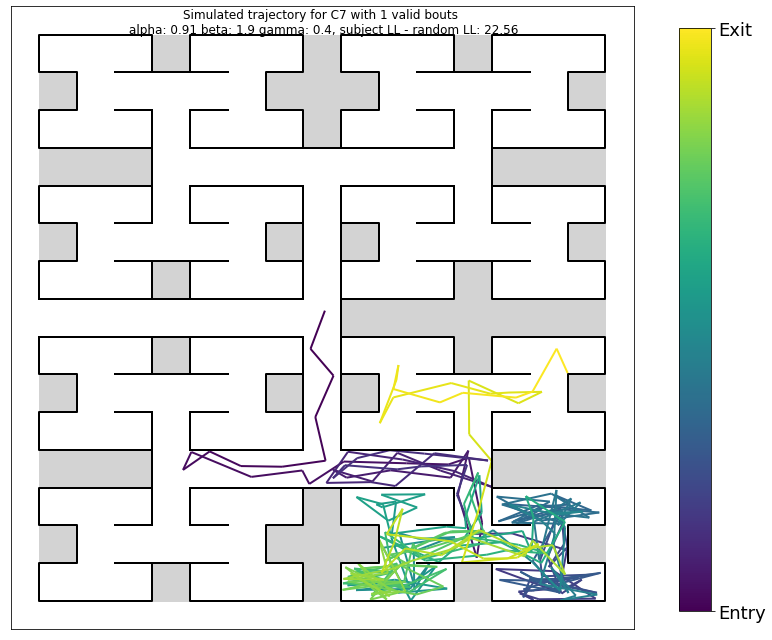

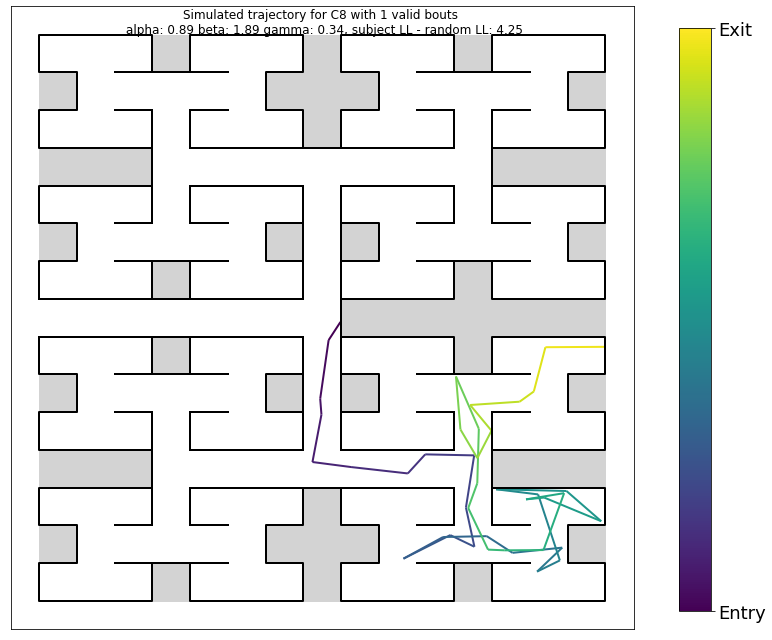

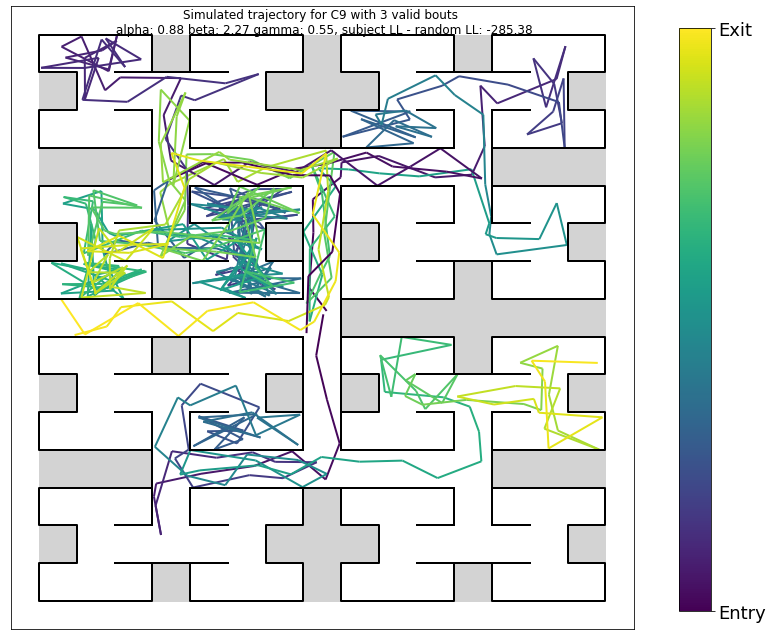

In [14]:
# Set trajectories for plotting
save_dir = 'C:/Users/kdilh/Documents/GitHub/MouseMaze/figures/TD0_firstreward/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for mouseID, nickname in enumerate(RewNames):
    state_hist_cell, state_hist_xy = nodes2cell(state_hist_AllMice[mouseID])
    figtitle = 'Simulated trajectory for '+nickname+' with '+str(valid_bouts[mouseID]) \
    +' valid bouts \n alpha: '+str(np.round(best_sub_fits[mouseID][0],2))+' beta: '+str(np.round(best_sub_fits[mouseID][1],2)) \
    +' gamma: '+str(np.round(best_sub_fits[mouseID][2],2)) + ', subject LL - random LL: ' + str(np.round(best_sub_fits[mouseID][3] - rand_LL[mouseID],2))
    plot_trajectory('all', save_dir, nickname, figtitle)  # enter a single episode ID or enter 'all'

### One-step SARSA <a id='#oneStepSARSA'></a>
Online TD-control algorithm which estimates state-action values, Q(s,a)
 - States: 127 maze nodes
 - Terminal states: maze entry, 127 and reward port, 116
 - Actions: 3 actions for each state (except for end nodes)
 - Rewards: 0 on all states except for 1 on the water port

Pseudocode
- Softmax action selection
- Action-value update: $Q(s,a) \leftarrow Q(s,a) + \alpha*(R + \gamma*Q(s',a') - Q(s,a))$

In [ ]:
# Define one-step SARSA model

# Set environment parameters
S = 127
A = 3
RT = 1
Q_nodemap = get_SAnodemap(S,A)

# Set model parameters
alpha = 0.5  # learning rate
gamma = 0.9
beta = 20  # softmax exploration - exploitation
N = 5  # number of episodes to train over

# Initialize model parameters
Q = np.random.rand(S+1,A)  # state-action values
Q[127,:] = 0  # setting action-values of maze entry to 0
Q[116,:] = 0  # setting action-values of reward port to 0
Q[np.isnan(Q_nodemap)] = np.nan
state_hist_all = {}
total_reward = 0

for n in np.arange(N):
    # Initialize starting state,s0 to node 0 and selection action a0
    aprob = []
    choices = []
    s = 0
    for atype in np.arange(3):
        aprob.extend([np.exp(beta*Q[s,atype])/np.nansum(np.exp(beta*Q[s,:]))])
    a = np.random.choice([0,1,2],1,p=aprob)[0]
    state_hist = []
    
    # Begin episode
    while s!=127 and s!=116:
        # Record current state
        state_hist.extend([s])
        
        # Take action, observe reward and next state
        sprime = int(Q_nodemap[s,a])
        if sprime == 116:
            R = 1  # Receive a reward of 1 when transitioning to the reward port
            total_reward += 1
        else:
            R = 0
            
        # Choose next action, aprime from new state, sprime
        aprob = []
        choices = []
        for atype in np.arange(3):
            if not np.isnan(Q[sprime,atype]):
                aprob.extend([np.exp(Q[sprime,atype])/np.nansum(np.exp(Q[sprime,:]))])
                choices.extend([atype])
        aprime = np.random.choice(choices,1,p=aprob)[0]
        
        # Update action-value of previous state-action pair, Q[s,a]
        Q[s,a] += alpha * (R + gamma*Q[sprime,aprime] - Q[s,a])
        
        # Shift state and action values for the next time step
        a = aprime
        s = sprime
    state_hist.extend([s])
    state_hist_all[n] = state_hist

In [ ]:
# Plotting state-action values
fig, ax = plt.subplots(figsize=(30,800))
axhandle = ax.imshow(np.transpose(Q),cmap='YlGnBu')
ax.invert_yaxis()
ax.set_ylabel('Q (s,a)')
ax.set_xticks(np.arange(0,127,5))
ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
ax.set_xlabel('Nodes')
ax.set_title('State-action values for one-step SARSA with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
fig.colorbar(axhandle,fraction=0.005)

In [ ]:
# Set trajectories for plotting
state_hist_cell, state_hist_xy = nodes2cell(state_hist_all)

In [ ]:
plot_trajectory('all')  # enter a single episode ID or enter 'all'

## Plot Model Fits

In [ ]:
# Load best fit parameters for one-step SARSA
# best_sub_fits: dict with [alpha, beta, gamma, LL] for each rewarded mouse
best_sub_fits = pickle.load(open('stan/stan_results_1SARSA/best_sub_fits.p','rb'))
state_hist_AllMice, valid_bouts = oneStepSARSA(best_sub_fits,'Rew')

In [ ]:
# Calculating log likelihood for a random agent
random_LL = {}
rew_traj = pickle.load(open('stan/pre_reward_traj/rewMICE.p','rb'))
for mouseID, nickname in enumerate(RewNames):
    random_LL[mouseID] = 0
    for boutID, bout in enumerate(rew_traj[mouseID]):
        traj = rew_traj[mouseID][boutID]
        if traj[0] == 0:
            filter_traj = [val for val in traj if val!= -1]
            
            for node in filter_traj:
                if not node in lv6_nodes:
                    random_LL[mouseID] += np.log(1/3)

In [ ]:
# Plot likelihoods
fit_LL = [best_sub_fits[mouseID][3] for mouseID in np.arange(10)]
rand_LL = [random_LL[mouseID] for mouseID in np.arange(10)]
plt.figure()
plt.plot(np.arange(1,11),fit_LL,'*',label='fitted LL')
plt.plot(np.arange(1,11),rand_LL,'*',label='rand LL')
plt.legend()
plt.xticks(ticks=np.arange(1,11), labels=RewNames)
plt.xlabel('Rewarded Mouse Name')
plt.ylabel('Log Likelihood')
plt.title('Fit Results with one-step SARSA')

In [ ]:
# Set trajectories for plotting
for mouseID, nickname in enumerate(RewNames):
    state_hist_cell, state_hist_xy = nodes2cell(state_hist_AllMice[mouseID])
    print('Plotting simulated trajectory for', nickname, 'with', valid_bouts[mouseID],'valid bouts \n alpha: %.2f beta: %.2f gamma: %.2f LL: %.2f' 
          %(best_sub_fits[mouseID][0], best_sub_fits[mouseID][1], best_sub_fits[mouseID][2], best_sub_fits[mouseID][3]))
    plot_trajectory('all')  # enter a single episode ID or enter 'all'